Changes V1 to V2:
* Demand input changed for population input
* Demand is population * (disruption factor -1) ; disruption {1,2, continuous}

Changes V2 to V3:
* Opening costs, only for new FLs (assumption: Only one new FL for each iteration)
* added operations costs (assumption, no variable costs, only fixed)
* transportation costs similar to math model (assumption: SPs cannot supply demand points)
* Note: changed distance to self to 0. check if goes well.
* A_ijk is super computationally intensive 3d matrix. Therefore smarter algorithm than math formula: check routes
* included max_distribution_times
* excluded total_distribution_times

TODO:
Finish Model
- X make distinction between new FLs and already open FLs (opening costs + operations cost)
- X operations costs
- X redefine objective distribution times
- X reprogram costs: demand* distance for each link, not all.
- X distrupted distance similar to assumption: td, atd dt
- NO: opening costs can be made proportional to capacity??

In [1]:
# import for test case setup
import random


In [2]:
# %load "lib/fl_model_v3.py"
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For vincenty:
from geopy.distance import great_circle

__all__ = ["FL_model"]


# Classes
class demand_class:
    """Demand points such as affected cities or villages"""

    def __init__(self, name, x, y, demand):
        self.name = "DP{}".format(name)
        self.type = "demand"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.demand = demand


class supply_class:
    """Supply points such as airports or seaports"""

    def __init__(self, name, x, y, supply):
        self.name = "SP{}".format(name)
        self.type = "supply"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.supply = supply
        self.operational = 1


class facility_class:
    """(Temporary) Distribution centers to distribute supply to demand"""

    def __init__(self, name, x, y):
        self.name = "FL{}".format(name)
        self.type = "facility"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.operational = 0


# Instantiate case functions
# Instantiate model


# Create airport as a supply point
def create_supply_points(sup_xcors, sup_ycors,
                         supply_at_sp=0):  #XX, has no effect: uncapacitated

    #TODO get a list with specific supply values for each point
    supply_at_sps = [supply_at_sp for i in range(len(sup_xcors))]

    supply_points = []
    for i in range(len(sup_xcors)):
        supply_points.append(
            supply_class(
                name=i,
                x=sup_xcors[i],
                y=sup_ycors[i],
                supply=supply_at_sps[i]))
    return supply_points


# Create demand points
def create_demand_points(dp_xcors, dp_ycors, demand_at_dp):

    demand_at_dps = [demand_at_dp[i] for i in range(len(dp_xcors))]

    demand_points = []
    for i in range(len(dp_xcors)):
        demand_points.append(
            demand_class(
                name=i, x=dp_xcors[i], y=dp_ycors[i], demand=demand_at_dps[i]))
    return demand_points


# # Create possible facility locations
def create_facility_locations(fl_xcors, fl_ycors):

    facility_locations = []
    for i in range(len(fl_xcors)):
        facility_locations.append(
            facility_class(name=i, x=fl_xcors[i], y=fl_ycors[i]))
    return facility_locations


# Create matrix with all distances
def create_distance_matrix(
        all_nodes, dist_method, distance_to_self=0
):  #TODO distance to self = unlimited. Pay attention to this with route matrix osrm
    """
    Creates a matrix with distances between all nodes
    Input: list of all nodes (objects)
    Output: Matrix with distances from [i,j]
    i,j = from, to
    Note: Matrix is symmetric: distances[i,j] = distances[j,i]
    Note: Distance to self ([i,i]) is 100 times larger than largest distance in matrix
    """
    distances = np.zeros([len(all_nodes), len(all_nodes)])

    def calculate_distance(
            x1, y1, x2, y2,
            method):  # TODO: include kwarg in model that chooses method
        """
        Lat = Y Long = X
        (lat, lon) is coordinate notation used by geopy
        method: euclidean, great_circle, or from_osrm
        great_circle returns length in meters
        Validated
        """
        if method == "euclidean":
            dx = x1 - x2
            dy = y1 - y2
            return (dx**2 + dy**2)**0.5

        if method == "great_circle":
            # Geopy uses location order: Lat, Lon
            return great_circle((y1, x1), (y2, x2)).km

        if method == "from_osrm":
            print("not implemented yet")

    # calculate distance matrix
    for i in range(len(all_nodes)):  #For every row
        for j in range(len(all_nodes)):  #For every column
            distances[i, j] = calculate_distance(
                all_nodes[i].x,
                all_nodes[i].y,
                all_nodes[j].x,
                all_nodes[j].y,
                method=dist_method)

    # set distance to self to big distance
    for i in range(len(distances)):
        distances[i, i] = distance_to_self

    return distances


def create_disrupted_road_matrix(distances, multipliers, nodes):
    """
    input:XX
    nodes can be both a set of FLs or DP
    Output: XX
    Validated
    """

    def mirror_matrix(matrix, distance_to_self=0):
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError(
                'Matrix is not well shaped. Should have dimensions n,n, where n=n'
            )
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if i == j:  # put large numbers on the diagonals
                    matrix[i, j] = distance_to_self
                matrix[j, i] = (matrix[i, j])
        return matrix

    matrix = distances.copy()  # don't change distances

    node_id_s = [n.id for n in nodes]

    for i, node_id in enumerate(node_id_s):
        matrix[:, node_id] = matrix[:, node_id] * multipliers[i]

    matrix = mirror_matrix(matrix)

    return matrix


# allocate each demand point to either a supply point or a facility location
def create_allocation_matrix(supply_points, demand_points, facility_locations,
                             distances, FL_range):
    """
    Returns an allocation matrix for [n,h]
    if [n,h] is 1: node n is allocated to supply hub h
    The full size of the matrix is n*n
    indexes are based on node.id
    
    Assumptions:
    All allocations are made based on the minimum distance. NOT disrupted distance, because unknown.
    Supply points are not allocated to other nodes, since they are supplied by upstream logistics, which is out of scope    
    """

    # list of all IDs for operational supply points and facility locations
    # assumption: only FL can supply DP. If also SP: Add supply_points in this list comprehension
    operational_hubs_id = [
        a.id for a in supply_points + facility_locations if a.operational == 1
    ]

    all_nodes = supply_points + facility_locations + demand_points
    #allocation matrix of all_nodes x all_nodes
    allocation_matrix = np.zeros([len(all_nodes), len(all_nodes)])

    # for each operational facility location:
    # we skip supply points, because we don't consider upstream logistics
    for fl in [fl for fl in facility_locations if fl.operational == 1]:
        # choose closest supply point (if multiple)           # XX is still necessary? not used here: (distance to iself is made very large while creating distance matrix)
        closest_i = np.argmin([
            distances[sp_id, fl.id]
            for sp_id in [sp.id for sp in supply_points]
        ])
        # allocate me to that supply point
        allocation_matrix[fl.id, operational_hubs_id[closest_i]] = 1

    # For each demand point. allocate to closest FL
    operational_fls_id = [
        fl.id for fl in facility_locations if fl.operational == 1
    ]
    for dp in demand_points:
        # Assumption: Each demand point gets 1 location allocated. If 2 locations have same distance, choose first
        # check which supply point or facility location is closest
        # closest = the index of the minimum distance of the list of distances between this demand point and all supply points
        closest_d = np.min(
            [distances[fl_id, dp.id] for fl_id in operational_fls_id])
        closest_i = np.argmin(
            [distances[fl_id, dp.id] for fl_id in operational_fls_id])
        #         closest_d = np.min(
        #             [distances[hub_id, dp.id] for hub_id in operational_hubs_id])
        #         closest_i = np.argmin(
        #             [distances[hub_id, dp.id] for hub_id in operational_hubs_id])

        # Set allocation 1 if j is closest to this demand point (or i)
        #i: demand point index, j: supply point index
        if closest_d < FL_range:
            allocation_matrix[dp.id, operational_fls_id[closest_i]] = 1

    return allocation_matrix


################### Objectives ###################


def calc_costs(supply_points, facility_locations, demand_points,
               unit_opening_costs, unit_transport_cost, FL_operations_cost,
               distances, allocation_matrix):
    # 1. calc opening costs of facilities
    # assumption: supply point, i.e. airport, is already opened
    # assumption: Only one new FL for each iteration
    total_opening_costs = 1 * unit_opening_costs

    # 2. Calc transportation costs
    #     total_distance = (allocation_matrix * distances).sum()

    #TODO: Validate
    #     #Create array of all DPs and whether they are allocated to a SP or FL
    #     allocated_DPs = allocation_matrix[[dp.id for dp in demand_points],:].sum(axis=1)
    #     #Create array of demand for each DP
    #     demand_DPs = [dp.demand for dp in demand_points]
    #     # Multiply arrays to get supply for each DP
    #     supply = covered_demand = np.multiply(allocated_DPs,demand_DPs)

    #     transportation_costs = total_distance * unit_transport_cost * sum(supply)

    #create supply matrix
    supply_matrix = np.zeros(
        [len(supply_points + facility_locations + demand_points)] * 2)
    for i in [d.id for d in demand_points]:
        for j in [fl.id for fl in facility_locations]:
            if allocation_matrix[i, j] == 1:
                #             print(i,j, dist[j,i])
                #             print([dp.demand for dp in demand_points if dp.id == i])
                supply_matrix[j, i] = [
                    dp.demand for dp in demand_points if dp.id == i
                ][0]

    for j in [fl.id for fl in facility_locations]:
        for k in [sp.id for sp in supply_points]:
            if allocation_matrix[j, k] == 1:
                #             print(j,k, dist[j,k])
                supply_matrix[k, j] = supply_matrix.sum(axis=1)[j]

    # calculate supply matrix
    transport_costs = 0
    for j in [fl.id for fl in facility_locations]:
        for k in [sp.id for sp in supply_points]:
            transport_costs += (distances[j, k] * supply_matrix[k, j] * 1)

    for i in [dp.id for dp in demand_points]:
        for j in [fl.id for fl in facility_locations]:
            transport_costs += (distances[i, j] * supply_matrix[j, i] * 1)
    print(transport_costs)

    # 3. calc operations costs
    nr_opened_fl = sum([fl.operational for fl in facility_locations])
    operations_cost = nr_opened_fl * FL_operations_cost

    return total_opening_costs + transport_costs + operations_cost


#     Minimise total uncovered demand
def calc_tot_uncov_demand(allocation_matrix, demand_points):
    """
    input: allocation matrix and list of demand points
    output: total uncovered demand (float)
    
    Validated
    """
    #Create array of all DPs and whether they are allocated to a SP or FL
    allocated_DPs = allocation_matrix[[dp.id for dp in demand_points], :].sum(
        axis=1)
    #Create array of demand for each DP
    demand_DPs = [dp.demand for dp in demand_points]
    # Multiply arrays to get supply for each DP
    covered_demand = np.multiply(allocated_DPs, demand_DPs)
    total_demand = sum(demand_DPs)
    return total_demand - sum(covered_demand)


#     Minimise uncovered demand points
def calc_uncov_DPs(allocation_matrix, demand_points):
    """
    Input: allocation matrix and list of demand points
    Output: number of demand points that has not been allocated
    
    Validated
    """
    # create array of all DPs and whether they are allocated to a SP or FL
    allocated_DPs = allocation_matrix[[dp.id for dp in demand_points], :].sum(
        axis=1)
    n_uncov_DPs = len(demand_points) - sum(allocated_DPs)
    return int(n_uncov_DPs)


# #     Minimise Total Distribution Times
# def calc_tot_distr_time(allocation_matrix, road_distances, speed):
#     """
#     road_distances = disrupted roads
#     """
#     total_distances = allocation_matrix * road_distances
#     tot_distr_time = total_distances.sum() / speed  # distance / speed = time
#     return tot_distr_time


def calc_max_distr_time(allo_matrix, disrdist, speed, supply_points,
                        facility_locations, demand_points):
    routes = []
    for i in [dp.id for dp in demand_points]:
        if sum(allo_matrix[i, :]) == 1:
            for j in [fl.id for fl in facility_locations]:
                if allo_matrix[i, j] == 1:
                    for k in [sp.id for sp in supply_points]:
                        if allo_matrix[j, k]:
                            routes.append([i, j, k])

    route_times = []
    for r in routes:
        r_dist = disrdist[r[0], r[1]] + disrdist[r[1], r[2]]
        route_times.append(r_dist / speed)

    return max(route_times)


# Functions for plotting
def plotting_create_allocation_lines(all_nodes, allocation_matrix):

    allocation_lines = np.zeros([len(all_nodes), 4])
    # creates matrix x1,y1,x2,y2
    for i, line in enumerate(zip(allocation_matrix)):
        if allocation_matrix[i].sum() == 0:
            continue
        allocation_lines[i, 0:2] = list(all_nodes[i].location)
        # Assumption: Only 1 location allocated # if changing: loop over list comprehension: [more than 0 allocated]
        allocation_lines[i, 2:4] = list((all_nodes)[np.argmax(line)].location)

    return allocation_lines


def plotting_plot_map(demand_points,
                      facility_locations,
                      supply_points,
                      allocation_lines=False):

    xmax = max(
        [n.x for n in demand_points + facility_locations + supply_points]) + 1
    xmin = min(
        [n.x for n in demand_points + facility_locations + supply_points]) - 1
    ymax = max(
        [n.y for n in demand_points + facility_locations + supply_points]) + 1
    ymin = min(
        [n.y for n in demand_points + facility_locations + supply_points]) - 1

    plt.axis([xmin, xmax, ymin, ymax])

    for x in demand_points:
        plt.scatter(x.x, x.y, c="green", marker="<")

    for x in facility_locations:
        if x.operational == 0:
            plt.scatter(x.x, x.y, c="red", marker="x", s=10)
        if x.operational == 1:
            plt.scatter(x.x, x.y, c="blue", marker="x", s=50)
    for x in supply_points:
        plt.scatter(x.x, x.y, c="blue", marker=">")

    # plot allocation lines
    if allocation_lines is not False:
        for line in allocation_lines:
            plt.plot(line[[0, 2]], line[[1, 3]], c="green")


def FL_model(
        unit_opening_costs,
        unit_transport_cost,  # Cost for transporting one unit of supplies
        FL_operations_cost,
        graphical_representation=False,
        FL_range=2,
        dist_method="euclidean",
        lorry_speed=60,  # km/h. Speed is Average speed. Constant, because roads are individually disrupted.
        **kwargs):
    """
    Inputs:
    dist_method: euclidean or great_circle
    Returns: Objectives, Constraints
    """

    #unpack kwargs
    keys = sorted(kwargs.keys())
    sp_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'SPX']]
    sp_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'SPY']]
    dp_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPX']]
    dp_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPY']]
    fl_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLX']]
    fl_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLY']]

    fl_operational = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLO']]

    disruption_DPs = [kwargs[x] for x in [k for k in keys if k[:5] == 'DSRDP']]
    disruption_FLs = [kwargs[x] for x in [k for k in keys if k[:5] == 'DSRFL']]

    #TODO Assign demand to demand points
    dp_pop = [kwargs[x] for x in [k for k in keys if k[:5] == 'DPpop']]

    #assumption: demand is proportionate to disruption. (so is disrupted travel time)
    dp_demand = np.array(dp_pop) * np.array(disruption_DPs)

    # set up model
    supply_points = create_supply_points(sp_xcors, sp_ycors)
    demand_points = create_demand_points(dp_xcors, dp_ycors, dp_demand)
    facility_locations = create_facility_locations(fl_xcors, fl_ycors)

    # Organise all nodes and create distance matrix
    all_nodes = supply_points + facility_locations + demand_points
    # Give all nodes in model an identifier corresponding to position in matrix
    for i in range(len(all_nodes)):
        all_nodes[i].id = i

    # Check if things are right
    if len(facility_locations) != len(fl_operational):
        print("Length FL arrays not equal, FL_model:", len(facility_locations),
              len(fl_operational))

    # Set operational FLs from levers
    for i, fl in enumerate(facility_locations):
        fl.operational = fl_operational[i]

    distances = create_distance_matrix(all_nodes, dist_method=dist_method)

    # calculate road disruptions for FLs
    disr_roads1 = create_disrupted_road_matrix(distances, disruption_FLs,
                                               facility_locations)
    # calculate road disruptions for DPs
    disr_roads = create_disrupted_road_matrix(disr_roads1, disruption_DPs,
                                              demand_points)

    allocation_matrix = create_allocation_matrix(
        supply_points, demand_points, facility_locations, distances, FL_range)
    # Assumption: allocation based on euclidean distance (because roads and road conditions are unknown)

    # determine objectives

    #     Minimise total costs
    #         Total Opening costs
    #         Total Transportation costs
    total_costs = calc_costs(supply_points, facility_locations, demand_points,
                             unit_opening_costs, unit_transport_cost,
                             FL_operations_cost, disr_roads, allocation_matrix)

    #     Minimise total uncovered demand
    total_uncovered_demand = calc_tot_uncov_demand(allocation_matrix,
                                                   demand_points)

    #     Minimise uncovered demand points
    nr_uncovered_DPs = calc_uncov_DPs(allocation_matrix, demand_points)

    #     Minimise Total Distribution Times
    #     total_distr_time = calc_tot_distr_time(allocation_matrix, disr_roads,
    #                                            lorry_speed)

    max_distr_time = calc_max_distr_time(allocation_matrix, disr_roads,
                                         lorry_speed, supply_points,
                                         facility_locations, demand_points)
    print(max_distr_time)
    # give a graphical representation of instantiation and allocation
    if graphical_representation == True:
        allocation_lines = plotting_create_allocation_lines(
            all_nodes, allocation_matrix)

        plotting_plot_map(demand_points, facility_locations, supply_points,
                          allocation_lines)
        plt.show()

    return total_costs, nr_uncovered_DPs, total_uncovered_demand, max_distr_time, sum(
        [fl.operational for fl in facility_locations])


#     return allocation_matrix, disr_roads, supply_points, facility_locations, demand_points

# Model test

In [3]:
# For direct input model
nr_of_SPs = 1
nr_of_DPs = 5
nr_of_FLs = 6
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
areasize = 10

# Disruptions for each node

# DSR = Disruption Demand Points
# Transport: 0 or 50% more, for traveling that distance
# Demand: 0 or 100% of population ((DSR - 1)* population)
# Assumption: cities hit harder, have more demand and are harder to reach. 
# Assumption_cont: Demand and Transport are equally proportionate affected by disaster
DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(nr_of_DPs)}
DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(nr_of_FLs)}

# Coordinates
SPX = {"SPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
SPY = {"SPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
DPX = {"DPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
DPY = {"DPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
FLX = {"FLX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}

FLO={"FLO0":1,"FLO1":1 ,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

#Population
DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}

432.46174311100583
6.67696148800183


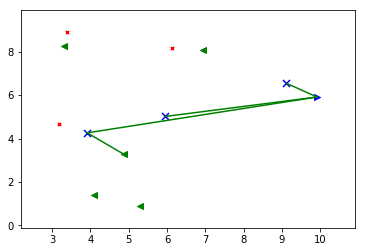

(1132.461743111006, 4, 431.7264636295717, 6.67696148800183, 3)

In [4]:
# costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, nr_op_fls = 
# allo_matrix, disrdist,supply_points, facility_locations,  demand_points  = 
FL_model(
    100,
    1,
    200,
    True,
    FL_range=2,
    dist_method="euclidean",
    lorry_speed=2,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL,
    **DPpop)

## Before:
This is the result as of before

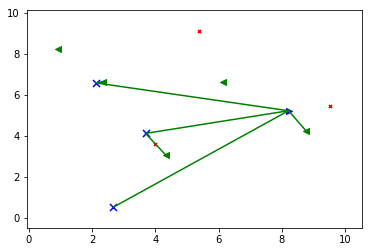

(4752.879741830765, 2, 264.8995461110201, 0.3631873521519044, 3)

In [10]:
# costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, nr_op_fls = 
FL_model(
    100,
    1,
    True,
    FL_range=2,
    dist_method="euclidean",
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL,
    **DPpop)

## Backup

In [ ]:
def calc_costs(facility_locations, demand_points, unit_opening_costs, unit_transport_cost, FL_operations_cost,
               distances, allocation_matrix):
    # 1. calc opening costs of facilities
    # assumption: supply point, i.e. airport, is already opened
    # assumption: Only one new FL for each iteration
    total_opening_costs = 1 * unit_opening_costs

    # 2. Calc transportation costs
    total_distance = (allocation_matrix * distances).sum()
    
    #TODO: Validate
    #Create array of all DPs and whether they are allocated to a SP or FL
    allocated_DPs = allocation_matrix[[dp.id for dp in demand_points],:].sum(axis=1)
    #Create array of demand for each DP
    demand_DPs = [dp.demand for dp in demand_points]
    # Multiply arrays to get supply for each DP
    supply = covered_demand = np.multiply(allocated_DPs,demand_DPs)
    
    transportation_costs = total_distance * unit_transport_cost * sum(supply)
    
    # 3. calc operations costs
    nr_opened_fl = sum([fl.operational for fl in facility_locations])
    operations_cost = nr_opened_fl * FL_operations_cost
    
    return total_opening_costs + transportation_costs + operations_cost






### FL model
    total_costs = calc_costs(facility_locations, demand_points, unit_opening_costs,
                             unit_transport_cost, FL_operations_cost, distances, allocation_matrix)


In [41]:
#create supply matrix
supply_matrix = np.zeros([len(supply_points + facility_locations + demand_points)]*2)
for i in [d.id for d in demand_points]:
    for j in [fl.id for fl in facility_locations]:
        if all_matrix[i,j] == 1:
#             print(i,j, dist[j,i])
#             print([dp.demand for dp in demand_points if dp.id == i])
            supply_matrix[j,i] = [dp.demand for dp in demand_points if dp.id == i][0]

for j in [fl.id for fl in facility_locations]:
    for k in [sp.id for sp in supply_points]:
        if all_matrix[j,k]==1:
#             print(j,k, dist[j,k])
            supply_matrix[k,j] = supply_matrix.sum(axis=1)[j]

# calculate supply matrix
transport_costs = 0
for j in [fl.id for fl in facility_locations]:
    for k in [sp.id for sp in supply_points]:
        transport_costs += (dist[j,k] * supply_matrix[k,j] * 1)

for i in [dp.id for dp in demand_points]:
    for j in [fl.id for fl in facility_locations]:
        transport_costs += (dist[i,j] * supply_matrix[j,i]* 1)
print(transport_costs)

78.97381361251587
